In [2]:
import tensorflow as tf

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
import numpy as np
train_images.as_numpy_iterator().next()

array([[[0.6240809 , 0.62800246, 0.6387868 ],
        [0.6186887 , 0.6279412 , 0.6369485 ],
        [0.61960787, 0.63529414, 0.64215684],
        ...,
        [0.5362745 , 0.5441176 , 0.54019606],
        [0.53186274, 0.54656863, 0.5495098 ],
        [0.52365196, 0.5442402 , 0.54264706]],

       [[0.6129289 , 0.62169117, 0.6365809 ],
        [0.6112745 , 0.62647057, 0.6392157 ],
        [0.61519605, 0.63039213, 0.6431373 ],
        ...,
        [0.53333336, 0.5411765 , 0.5372549 ],
        [0.53039217, 0.54509807, 0.5480392 ],
        [0.5382353 , 0.5539216 , 0.5627451 ]],

       [[0.60784316, 0.61960787, 0.6392157 ],
        [0.6113358 , 0.6231005 , 0.64270836],
        [0.60245097, 0.6142157 , 0.6338235 ],
        ...,
        [0.5373162 , 0.54515934, 0.5412378 ],
        [0.53425246, 0.54895836, 0.5518995 ],
        [0.5302696 , 0.5459559 , 0.54987746]],

       ...,

       [[0.625674  , 0.6295956 , 0.6374387 ],
        [0.62352943, 0.627451  , 0.63529414],
        [0.6279412 , 0

In [8]:
import json
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [tf.constant([label['class']], dtype=tf.uint8)], tf.constant(label['bbox'], dtype=tf.float16)


In [9]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
test_labels.as_numpy_iterator().next()

(array([[1]], dtype=uint8),
 array([0.386 , 0.5596, 0.6885, 0.889 ], dtype=float16))

In [13]:
#checking partition lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2340, 2340, 660, 660, 300, 300)

The size of dataset has significantly increased now

In [14]:
#creating final datasets
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(500)
train = train.batch(8)
train = train.prefetch(4)


test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(200)
test = test.batch(8)
test = test.prefetch(4)


val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(60)
val = val.batch(8)
val = val.prefetch(4)

Now we have built our dataset

In [15]:
data_samples = train.as_numpy_iterator()

In [16]:
res = data_samples.next()

uncomment the code and run to see a sample

In [48]:
# import matplotlib.pyplot as plt
# import cv2
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4):
#     sample_image = res[0][idx]
#     sample_coords = res[1][1][idx]

#     sample_image = sample_image.copy()

#     cv2.rectangle(sample_image,
#                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
#                         (255,0,0), 2)

#     ax[idx].imshow(sample_image)


Making the deep learning model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [19]:
#will take a long time to download if first time
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [21]:
facetracker = build_model()

In [22]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
X, y = train.as_numpy_iterator().next()

In [24]:
X.shape

(8, 120, 120, 3)

In [25]:
y[0]

array([[[0]],

       [[0]],

       [[1]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]]], dtype=uint8)

In [26]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


(array([[0.4668606 ],
        [0.4629035 ],
        [0.485552  ],
        [0.4120995 ],
        [0.40410915],
        [0.4433425 ],
        [0.43520385],
        [0.43481946]], dtype=float32),
 array([[0.4521102 , 0.3306972 , 0.49113575, 0.49165347],
        [0.49913156, 0.34428954, 0.58807176, 0.48153907],
        [0.572824  , 0.23127024, 0.48482373, 0.49142662],
        [0.4943738 , 0.31086162, 0.53515226, 0.48332328],
        [0.46522474, 0.32895392, 0.42057556, 0.4721236 ],
        [0.434251  , 0.35683602, 0.491054  , 0.5005412 ],
        [0.5007309 , 0.31726936, 0.53775007, 0.52910864],
        [0.53970313, 0.311217  , 0.5454217 , 0.52430147]], dtype=float32))

Define optimizers and LR

In [27]:
batches_per_epoch = len(train)/10
lr_decay = (1./0.75 -1)/batches_per_epoch

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

Creating locaization and classification loss

In [29]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [30]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Testing out losses

In [31]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9439127445220947>

In [32]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6422489881515503>

In [33]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.9439127445220947>

Training the Neural Network

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
      X, y = batch

      with tf.GradientTape() as tape:
        classes, coords = self.model(X, training=True)

        # Ensure reshaped labels match predictions
        y_0 = tf.reshape(y[0], [-1, 1]) 
        y_1 = tf.reshape(y[1], [-1, 4])  

        # Debugging Tensor Shapes
        tf.debugging.assert_shapes([
            (classes, ("B", 1)),  # B is batch size
            (y_0, ("B", 1)),
            (coords, ("B", 4)),
            (y_1, ("B", 4)),
        ])

        # Loss calculations
        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y_1, tf.float32), coords)

        total_loss = batch_localizationloss + 0.5 * batch_classloss

        # Gradient calculation and update
        grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

      return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def test_step(self, batch, **kwargs):
      X, y = batch

      # Model predictions
      classes, coords = self.model(X, training=False)

      # Reshape labels to match predictions
      y_0 = tf.reshape(y[0], [-1, 1])
      y_1 = tf.reshape(y[1], [-1, 4])  

      # Debugging Tensor Shapes
      tf.debugging.assert_shapes([
          (classes, ("B", 1)),  # B is batch size
          (y_0, ("B", 1)),
          (coords, ("B", 4)),
          (y_1, ("B", 4)),
      ])

      # Loss calculations
      batch_classloss = self.closs(y_0, classes)
      batch_localizationloss = self.lloss(tf.cast(y_1, tf.float32), coords)
      total_loss = batch_localizationloss + 0.5 * batch_classloss

      return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [35]:
model = FaceTracker(facetracker)

In [36]:
model.compile(opt, classloss, regressloss)

In [37]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - class_loss: 0.0983 - regress_loss: 0.3345 - total_loss: 0.3837 - val_class_loss: 0.0014 - val_regress_loss: 0.0407 - val_total_loss: 0.0414
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - class_loss: 0.0526 - regress_loss: 0.1456 - total_loss: 0.1719 - val_class_loss: 3.1508e-04 - val_regress_loss: 0.0090 - val_total_loss: 0.0092
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - class_loss: 0.0223 - regress_loss: 0.0873 - total_loss: 0.0985 - val_class_loss: 2.5196e-04 - val_regress_loss: 0.0287 - val_total_loss: 0.0289
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - class_loss: 0.0283 - regress_loss: 0.0768 - total_loss: 0.0910 - val_class_loss: 1.6543e-04 - val_regress_loss: 0.0116 - val_total_loss: 0.0117
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - class_loss: 0.0301 - regress_loss: 0.0636 - total_loss: 0.0786 - val_class_loss: 7.3745e-06 - val_regress_loss: 0.0202 - val_total_loss: 0.0202
Epoch 6/1

In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [47]:
from joblib import load , dump
dump(model , "face_tracking.joblib")

['face_tracking.joblib']

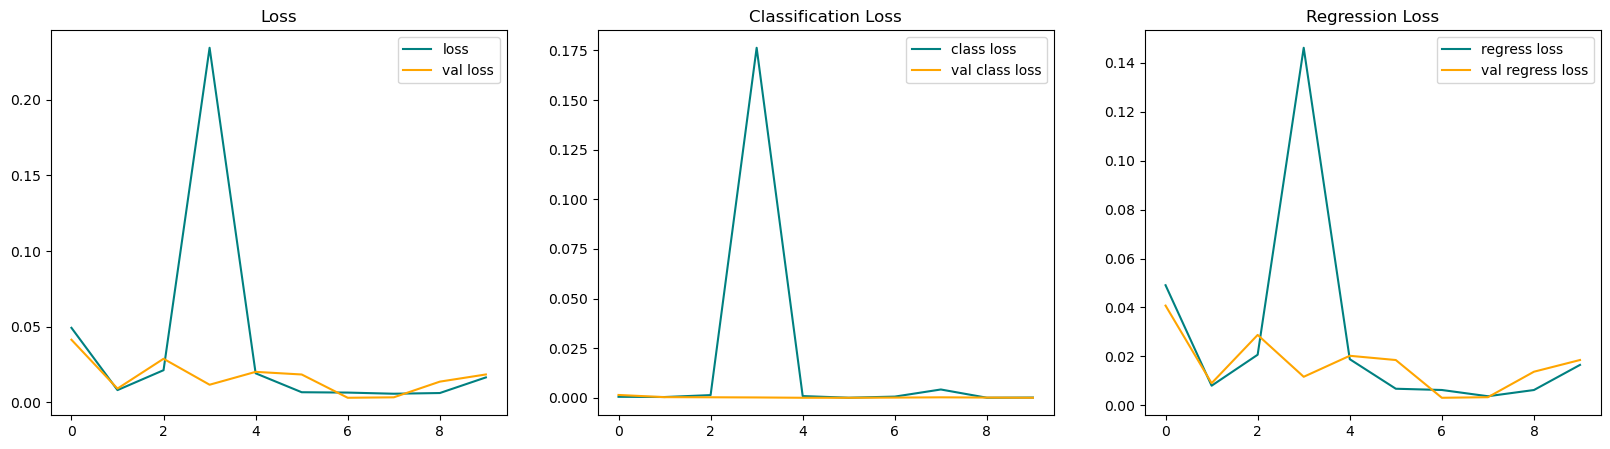

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [46]:
import cv2
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1